In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [26]:
# neatly format csv as a data frame

df = pd.read_csv("M9_off1___4000croppedDLC_resnet50_M9Jul27shuffle1_10000.csv").iloc[2:]
body_parts = ["head", "body", "tail"]
suffixes = ["_x", "_y", "_likelihood"]
df.columns = ["coords"] + [part+suffix for part in body_parts for suffix in suffixes]
df.set_index("coords", inplace=True)
df.drop([part + suffixes[2] for part in body_parts], axis=1, inplace=True)

df

,head_x,head_y,body_x,body_y,tail_x,tail_y
coords,,,,,,
0,298.858642578125,128.2902374267578,243.80703735351562,126.58676147460938,252.56478881835938,165.06590270996094
1,300.1903381347656,127.70858001708984,243.49661254882812,126.6867446899414,245.2889404296875,165.868408203125
2,299.782470703125,129.35372924804688,243.23265075683594,126.3281021118164,253.19378662109375,163.91329956054688
3,300.1647644042969,129.3058624267578,243.2828826904297,126.43618774414062,256.505615234375,162.9633331298828
4,300.40447998046875,128.13739013671875,243.46176147460938,125.89984130859375,258.12890625,162.49609375
...,...,...,...,...,...,...
10375,227.15093994140625,104.13713836669922,158.84471130371094,116.24222564697266,115.34121704101562,92.13932800292969
10376,227.15174865722656,104.12874603271484,158.84005737304688,116.25027465820312,115.3482437133789,92.13616943359375
10377,227.15597534179688,104.12382507324219,158.83824157714844,116.25094604492188,115.34794616699219,92.13558959960938


The total distance traveled is 5968.51
The total angle traveled is 168.58


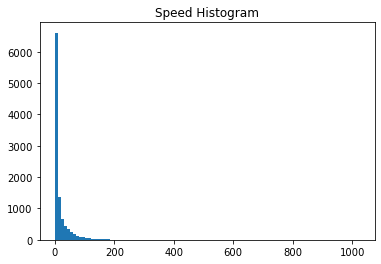

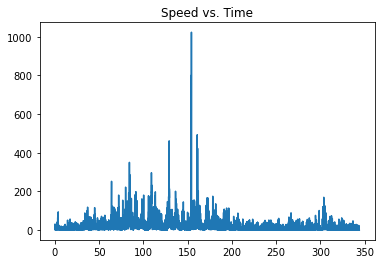

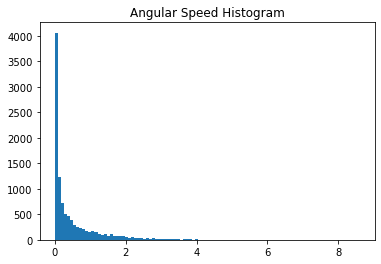

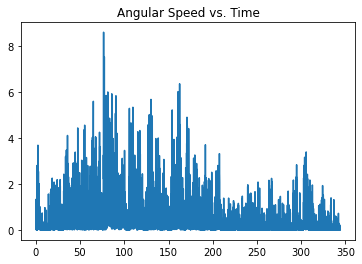

In [28]:
# constants
LPP = 0.5 # length per pixel (mm)
TPF = 344/10380 # time per frame (s)

# --- helper functions ---
def load_vec(col_name):
    return df[col_name].astype("float").to_numpy() * LPP
    # change to this line if using Jupyter:
    # return np.array(df[col_name].astype("float")) * LPP

def diff_arr(arr):
    return np.abs(arr[1:] - arr[0:-1])
# --- end of helper functions ---

# position information
num_frames = df.shape[0]
body_x = load_vec("body_x")
body_y = load_vec("body_y")
head_x = load_vec("head_x")
head_y = load_vec("head_y")

# direction information
dir_x = head_x - body_x
dir_y = head_y - body_y
dir_xy = np.vstack((dir_x, dir_y)).T

"""
np.arctan() returns a value between -pi/2 and pi/2.
We want to map these angles from 0 to 2*pi depending on the quadrant of the vector.
"""
angles = np.arctan(dir_y / dir_x)
q2 = np.logical_and(dir_x < 0, dir_y > 0)
q3 = np.logical_and(dir_x < 0, dir_y < 0)
q4 = np.logical_and(dir_x > 0, dir_y < 0)
angles[q2] = np.pi - np.abs(angles[q2])
angles[q3] = np.pi + angles[q3]
angles[q4] = 2*np.pi + angles[q4]
assert(np.min(angles) >= 0)
assert(np.max(angles) <= 2*np.pi)

# speed information
speed = np.sqrt(diff_arr(body_x)**2 + diff_arr(body_y)**2) / TPF
total_dist = np.sum(speed * TPF)
print(f"The total distance traveled is {total_dist:.2f}")

"""
In a given time unit, the mouse may have rotated clockwise or counterclockwise.
We consider both directions and choose the smaller value as the angular displacement.
"""
angular_speed = np.min(np.array([diff_arr(angles), 2*np.pi-diff_arr(angles)]).T, axis=1)/ TPF
total_angle = np.sum(angular_speed * TPF)
print(f"The total angle traveled is {total_angle:.2f}")

# plots
time = np.arange(1, speed.size+1) * TPF
plt.hist(speed, bins=100)
plt.title("Speed Histogram")
plt.show()

plt.plot(time, speed)
plt.title("Speed vs. Time")
plt.show()

plt.hist(angular_speed, bins=100)
plt.title("Angular Speed Histogram")
plt.show()

plt.plot(time, angular_speed)
plt.title("Angular Speed vs. Time")
plt.show()


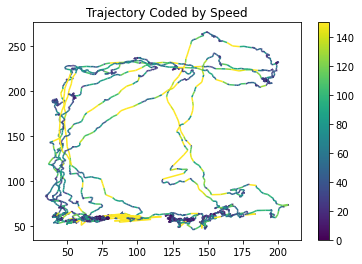

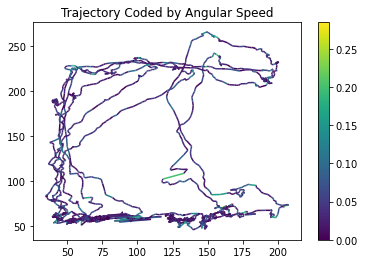

In [17]:
# color-coded trajectory plots
def plot_trajectory(color_arr):
    fig, ax = plt.subplots()
    coll = LineCollection(segments, array=color_arr, cmap="viridis")
    ax.add_collection(coll)
    ax.autoscale_view()
    fig.colorbar(coll)

body_xy = np.vstack((body_x, body_y)).T
body_xy = body_xy.reshape(-1,1,2)
segments = np.hstack((body_xy[:-1], body_xy[1:])) # (10379, 2, 2)

# set threshold to increase visualization contrast
speed_t = np.copy(speed)
angular_speed_t = np.copy(angular_speed)
speed_t[speed_t > 150] = 150
angular_speed[angular_speed_t > 0.3] = 0.3

plot_trajectory(speed_t)
plt.title("Trajectory Coded by Speed")
plt.show()

plot_trajectory(angular_speed_t)
plt.title("Trajectory Coded by Angular Speed")
plt.show()

In [ ]:
import matplotlib.animation as animation
plt.rcParams["animation.ffmpeg_path"] = "C:\\Users\\Nathan\Desktop\\ffmpeg-5.1.2-essentials_build\\bin\\ffmpeg.exe"

# --- draw blank plot ---
fig, ax = plt.subplots()

# line segments
coll = LineCollection([], array=speed, cmap="viridis")
ax.add_collection(coll)
fig.colorbar(coll)

vector = ax.quiver([],[]) # direction vector

# title with metrics
title = ax.text(80, 500, "")

# chart dimensions
padding=20
ax.set_xlim([np.amin(body_x)-padding, np.amax(body_x)+padding])
ax.set_ylim([np.amin(body_y)-padding, np.amax(body_y)+padding])
# --- end of draw blank plot ---

def generate_frame(idx, coll):
    coll.set_segments(segments[:idx]) # update segments

    # update direction vector
    global vector
    vector.remove()
    vector = ax.quiver(body_x[idx], body_y[idx], dir_x[idx], dir_y[idx])

    # update title
    title.set_text(f"Orientation: {angles[idx]:.2f} radians, Speed: {speed[idx]:.2f} units/s")

    return coll,

# saving animation
anim = animation.FuncAnimation(fig, generate_frame,
    frames = num_frames, 
    fargs = [coll],
    interval = 1,
    blit = True)

FFwriter = animation.FFMpegWriter(fps=15)
anim.save('trajectory.mp4', writer=FFwriter)